In [205]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [206]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [207]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'cmu serif'

page_width = 6.75 # aistats width

In [221]:
ds_name = 'cifar20_100' #'gtsrb' 'cifar10' 'cifar20_100'

In [222]:
results_path = f'../runs_maml/{ds_name}/softmax'

In [223]:
# l2d_type_lst = ['single_finetune', 'single_maml', 'single', 'pop']
l2d_type_lst = ['single_finetune', 'single_maml', 'single', 'pop', 'pop_attn']
# p_out_lst = [0.1,0.2,0.4,0.6,0.8,0.95]
p_out_lst = [0.1,0.2,0.4,0.6,0.8,0.95,1.0]
seed_lst = [1071,3918,4420,5251,6637]
metrics_lst = ['cov', 'sys_acc', 'exp_acc', 'clf_acc', 'exp_acc_alone', 'clf_acc_alone', 'val_loss']

results = {}
for l2d_type in l2d_type_lst:
    results[l2d_type] = {}
    metrics_all = {metric:[[] for _ in range(len(p_out_lst))] for metric in metrics_lst}

    for ii,p_out in enumerate(p_out_lst):
        for seed in seed_lst:
            if l2d_type == 'single_finetune':
                fn_path = os.path.join(results_path, f'l2d_single', f'p{p_out}_seed{seed}', 'eval1.0_finetune.log')
            elif l2d_type == 'single_maml':
                fn_path = os.path.join(results_path, f'l2d_{l2d_type}', f'p{p_out}_seed{seed}', 'eval1.0_finetune.log')
            else:    
                fn_path = os.path.join(results_path, f'l2d_{l2d_type}', f'p{p_out}_seed{seed}', 'eval1.0.log')

            try:
                line = open(fn_path).readline().rstrip()
            except FileNotFoundError:
                print(fn_path)
            else:
                line_split_grp = [line.split()[i:i+2] for i in range(0, len(line.split()),2)]
                for [metric,val] in line_split_grp:
                    if metric=='cov':
                        cov = val.split('/')
                        metrics_all[metric][ii].append(int(cov[0])/int(cov[1]))
                    else:
                        metrics_all[metric][ii].append(float(val))

    for metric, vals in metrics_all.items():
        results[l2d_type][metric] = np.vstack(vals)

In [224]:
c_single = mpl.colormaps['Set1'](0) # red
c_pop = mpl.colormaps['Set1'](1) # blue
c_single_finetune = mpl.colormaps['Set1'](3) # purple
c_single_maml = mpl.colormaps['Set1'](4) # orange

In [225]:
metrics_to_text = {
    'cov':'Coverage',
    'sys_acc': 'System accuracy (\%)',
    'exp_acc': 'Expert accuracy\non deferred examples (\%)',
    'clf_acc': 'Classifier accuracy\n on non-deferred examples',
    'clf_acc_alone': 'Classifier accuracy\n on all examples',
    'val_loss': 'Test loss'
}

In [226]:
l2d_type_to_text = {
    'single': 'single-L2D',
    'single_finetune': 'L2D-Pop (finetune)',
    'pop': 'L2D-Pop (NP)',
    'pop_attn': 'L2D-Pop (NP+attention)',
    'single_maml': 'L2D-Pop (MAML)'
}

In [227]:
# dataset_to_yticks_expacc = {
#     'cifar10' : [20,40,60,80,100]
# }

dataset_to_yticks_sysacc = {
    'cifar10' : np.linspace(82.5,96,4),
    'cifar20_100' : np.arange(77,85,2.5),
    'gtsrb' : np.linspace(88,100,4),
}

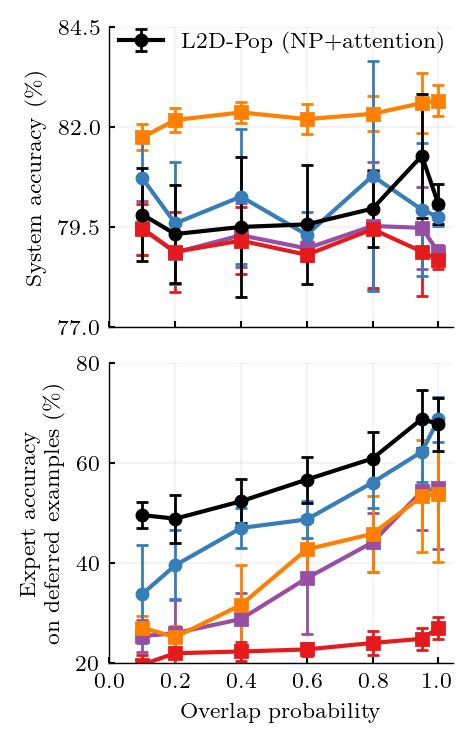

In [233]:
show_ylabels = True #True #False
fig_w = 2.25 if show_ylabels else 2.0

fig,axs = plt.subplots(2,1,figsize=(fig_w,3.6), constrained_layout=True)

metric_to_col = {'single':c_single,'pop':c_pop, 'pop_attn':'k', 'single_finetune':c_single_finetune, 'single_maml':c_single_maml}
metric_to_marker = {'single':'s-','pop':'o-', 'pop_attn':'o-', 'single_finetune':'s-', 'single_maml':'s-'}
errbar_args={'capsize':2, 'markersize':4, 'elinewidth':1, 'capthick':1, 'lw':1.5} # 'fmt':'o-'

fs_ax_lbl=8
fs_ax_ticks = 8
fs_ax_title = 8

for ax,metric in zip(axs,['sys_acc','exp_acc']):
    for l2d_type in l2d_type_lst:
        metric_mean = np.mean(results[l2d_type][metric], axis=1)
        metric_std = np.std(results[l2d_type][metric], axis=1)
        overlap_prob = np.array(p_out_lst)
        ax.errorbar(overlap_prob, metric_mean, yerr=metric_std, label=l2d_type_to_text[l2d_type], \
                c=metric_to_col[l2d_type], fmt=metric_to_marker[l2d_type], **errbar_args)
    ax.set_xticks([0,0.2,0.4,0.6,0.8,1])
    
    if show_ylabels:
        ax.set_ylabel(metrics_to_text[metric], fontsize=fs_ax_lbl)
    ax.grid(True, alpha=0.15)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(direction='in', labelsize=fs_ax_ticks,length=2., width=0.75)
    [x.set_linewidth(.5) for x in ax.spines.values()]

axs[0].tick_params(labelbottom=False)    
axs[1].set_xlabel('Overlap probability', fontsize=fs_ax_lbl)
if ds_name == 'cifar20_100':
    axs[1].set_yticks([20,40,60,80])
else:
    axs[1].set_yticks([20,40,60,80,100])
axs[1].set_ylim(20)
axs[0].set_yticks(dataset_to_yticks_sysacc[ds_name])

if ds_name != 'cifar20_100':
    if show_ylabels:
        handles, labels = axs[0].get_legend_handles_labels()
        order = [2,0,1,3]
        leg = fig.legend([handles[idx] for idx in order],[labels[idx] for idx in order], \
                         fontsize=fs_ax_title,frameon=False, loc='upper center', bbox_to_anchor=(0.56, 1.0))
        leg.get_frame().set_linewidth(0.5)
else:
    handles, labels = axs[0].get_legend_handles_labels()
    order = [4]
    leg = fig.legend([handles[idx] for idx in order],[labels[idx] for idx in order], \
                     fontsize=fs_ax_title,frameon=False, loc='upper center', bbox_to_anchor=(0.6, 1.0))
    leg.get_frame().set_linewidth(0.5)
    
# fig.savefig(f'exp_{ds_name}_maml.pdf', dpi=600, facecolor='white', bbox_inches='tight', pad_inches=0.01)